In [1]:
from collections import defaultdict
import os, urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn, sklearn.model_selection, sklearn.linear_model

from projection_simplex_vectorized import projection_simplex
from postprocess import PostProcessorDP
import utils

split_ratio_for_postprocessing = 0.5

seed = 33
rng = np.random.default_rng(seed)
bw = 1 / 2000
n_perturbations_train = 10
n_perturbations_eval = 1000

## Download and pre-process UCI Adult dataset

In [2]:
features = [
    "Age", "Workclass", "fnlwgt", "Education", "Education-Num",
    "Martial Status", "Occupation", "Relationship", "Race", "Sex",
    "Capital Gain", "Capital Loss", "Hours per week", "Country", "Target"
]

train_path = "data/adult/adult.data"
test_path = "data/adult/adult.test"
if any([not os.path.exists(p) for p in [train_path, test_path]]):
  os.makedirs("data/adult", exist_ok=True)
  urllib.request.urlretrieve(
      "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
      train_path)
  urllib.request.urlretrieve(
      "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
      test_path)

original_train = pd.read_csv(train_path,
                             names=features,
                             sep=r"\s*,\s*",
                             engine="python",
                             na_values="?")
original_test = pd.read_csv(test_path,
                            names=features,
                            sep=r"\s*,\s*",
                            engine="python",
                            na_values="?",
                            skiprows=1)

original_train["Age-Binned"] = np.where(original_train["Age"] <= 50, "<=50",
                                        ">50")
original_test["Age-Binned"] = np.where(original_test["Age"] <= 50, "<=50",
                                       ">50")

In [3]:
def data_transform(df):
  """Normalize features."""
  binary_data = pd.get_dummies(df)
  scaler = sklearn.preprocessing.StandardScaler()
  data = pd.DataFrame(scaler.fit_transform(binary_data),
                      columns=binary_data.columns)
  data.index = df.index
  return data


original = pd.concat([original_train, original_test])
labels_original = original[["Target"
                           ]].replace("<=50K.",
                                      "<=50K").replace(">50K.", ">50K")
del original["Target"]
n_train = len(original_train)

label_names, labels = np.unique(labels_original, return_inverse=True)
n_classes = len(label_names)

data = data_transform(original)
train_data = data[:n_train]
train_labels = labels[:n_train]
test_data = data[n_train:]
test_labels = labels[n_train:]

In [4]:
# Define some utility functions


def get_group_labels_and_print_statistics(sensitive_attributes):

  df = original.copy()
  df["Target"] = np.array(label_names)[labels]
  groups = original[sensitive_attributes[0]]
  for attribute in sensitive_attributes[1:]:
    groups = np.add(np.add(groups, ", "), original[attribute])
  df["Group"] = groups
  df_grouped = df.groupby(["Target", "Group"]).size().unstack()
  counts = df_grouped.sum(axis=0)

  group_names, groups = np.unique(groups, return_inverse=True)
  n_groups = len(group_names)
  n_classes = len(df_grouped.index)

  print("Dataset statistics:")
  display(df_grouped / counts)
  display(pd.DataFrame(counts, columns=["Count"]).T)

  print()
  print("Perfect results if dataset equals population:")
  display(
      pd.DataFrame({
          "group_balanced_err": {
              "no_postprocess":
                  0.0,
              "postprocess":
                  PostProcessorDP().fit(
                      np.concatenate(
                          [np.eye(n_classes) for _ in range(n_groups)], axis=0),
                      np.repeat(np.arange(n_groups), n_classes),
                      p=np.nan_to_num((df_grouped.to_numpy() /
                                       counts.to_numpy())).T.flatten()).score_
          },
          "dp_gap": {
              "no_postprocess": utils.dp_gap(labels, groups),
              "postprocess": 0.0
          }
      }))

  return groups[:n_train], groups[n_train:], n_groups


def add_metrics_to_dict(dictionary, model_name, test_labels, test_preds,
                        test_groups, n_groups):
  dictionary["group_balanced_err"][model_name] = utils.error_rate(
      test_labels,
      test_preds,
      test_groups,
      w=np.ones(n_groups) / n_groups,
      n_groups=n_groups)
  dictionary["dp_gap"][model_name] = utils.dp_gap(test_preds,
                                                  test_groups,
                                                  n_classes=n_classes,
                                                  n_groups=n_groups)


def plot_results(eps, res, title):
  fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
  ax.scatter([list(res["group_balanced_err"].values())[0]],
             [list(res["dp_gap"].values())[0]],
             c="w",
             edgecolors="k",
             zorder=3)
  sc = ax.scatter(list(res["group_balanced_err"].values())[1:],
                  list(res["dp_gap"].values())[1:],
                  c=eps,
                  zorder=2)
  cbar = fig.colorbar(sc, ax=ax, label=r"$\epsilon$")
  ax.set_xlabel("Group-balanced error")
  ax.set_ylabel(r"$\Delta_{\mathrm{DP}}$")
  ax.set_title(title)
  ax.grid(True, which="both", zorder=0)
  plt.show()

## Sensitive attribute "Sex"

In [5]:
sensitive_attributes = ["Sex"]
train_groups, test_groups, n_groups = get_group_labels_and_print_statistics(
    sensitive_attributes)
train_data_pre, train_data_post, train_labels_pre, train_labels_post, train_groups_pre, train_groups_post = sklearn.model_selection.train_test_split(
    train_data,
    train_labels,
    train_groups,
    test_size=split_ratio_for_postprocessing,
    random_state=seed)
train_labels_pre_one_hot = pd.get_dummies(train_labels_pre)

Dataset statistics:


Group,Female,Male
Target,,
<=50K,0.890749,0.696233
>50K,0.109251,0.303767


Group,Female,Male
Count,16192,32650



Perfect results if dataset equals population:


,group_balanced_err,dp_gap
no_postprocess,0.000000,0.194516
postprocess,0.097258,0.000000


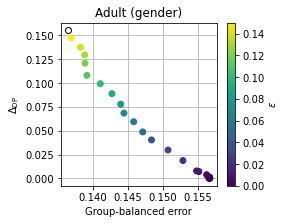

,group_balanced_err,dp_gap
no_postprocess,0.136483,0.155611
0.15,0.136944,0.147504
0.14,0.138280,0.137647
0.13,0.138878,0.129632
0.12,0.138924,0.120880
0.11,0.139199,0.108166
0.1,0.141088,0.099414
0.09,0.142745,0.088912
0.08,0.143988,0.077947
0.07,0.144448,0.068549


In [6]:
predictor = sklearn.linear_model.LinearRegression()
predictor.fit(train_data_pre, train_labels_pre_one_hot)
train_probas_post = projection_simplex(predictor.predict(train_data_post),
                                       axis=1)
test_probas = projection_simplex(predictor.predict(test_data), axis=1)

eps = [
    0.15, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03,
    0.02, 0.01, 0.008, 0.005, 0.002, 0.0015, 0.001, 0.0005, 0.0001, 0.0
]
res = defaultdict(dict)
add_metrics_to_dict(res, "no_postprocess", test_labels,
                    np.argmax(test_probas, axis=1), test_groups, n_groups)
for e in eps:
  postprocessor = PostProcessorDP().fit(train_probas_post,
                                        train_groups_post,
                                        eps=e)
  test_preds = postprocessor.predict(test_probas, test_groups)
  add_metrics_to_dict(res, e, test_labels, test_preds, test_groups, n_groups)

plot_results(eps, res, "Adult (gender)")
display(pd.DataFrame(res))

In [7]:
# Get q_by_group under eps=0 from last post-processor in previous cell
q_by_group = postprocessor.q_by_group_

import importlib
import utils

importlib.reload(utils)

predictor = sklearn.linear_model.LinearRegression()
predictor.fit(train_data_pre, train_labels_pre_one_hot)
train_probas_post = projection_simplex(predictor.predict(train_data_post),
                                       axis=1)
test_probas = projection_simplex(predictor.predict(test_data), axis=1)

train_probas_post = utils.perturb(rng,
                                   train_probas_post,
                                   bw=bw,
                                   repeat=n_perturbations_train)
train_labels_post = np.repeat(train_labels_post, n_perturbations_train)
train_groups_post = np.repeat(train_groups_post, n_perturbations_train)

test_probas_perturbed = utils.perturb(rng,
                                       test_probas,
                                       bw=bw,
                                       repeat=n_perturbations_eval)
test_labels_repeated = np.repeat(test_labels, n_perturbations_eval)
test_groups_repeated = np.repeat(test_groups, n_perturbations_eval)

eps = [0.0]
res = defaultdict(dict)
for e in eps:
  postprocessor = PostProcessorDP().fit(train_probas_post,
                                        train_groups_post,
                                        eps=e,
                                        q_by_group=q_by_group)
  test_preds = postprocessor.predict(test_probas_perturbed,
                                     test_groups_repeated)
  add_metrics_to_dict(res, e, test_labels_repeated, test_preds,
                      test_groups_repeated, n_groups)

print("With smoothing:")
display(pd.DataFrame(res))

With smoothing:


,group_balanced_err,dp_gap
0.0,0.156636,0.000055


## Sensitive attribute "Race"

In [8]:
sensitive_attributes = ["Race"]
train_groups, test_groups, n_groups = get_group_labels_and_print_statistics(
    sensitive_attributes)
train_data_pre, train_data_post, train_labels_pre, train_labels_post, train_groups_pre, train_groups_post = sklearn.model_selection.train_test_split(
    train_data,
    train_labels,
    train_groups,
    test_size=split_ratio_for_postprocessing,
    random_state=seed)
train_labels_pre_one_hot = pd.get_dummies(train_labels_pre)

Dataset statistics:


Group,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
Target,,,,,
<=50K,0.882979,0.730744,0.879189,0.876847,0.746013
>50K,0.117021,0.269256,0.120811,0.123153,0.253987


Group,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
Count,470,1519,4685,406,41762



Perfect results if dataset equals population:


,group_balanced_err,dp_gap
no_postprocess,0.000000,0.152235
postprocess,0.057082,0.000000


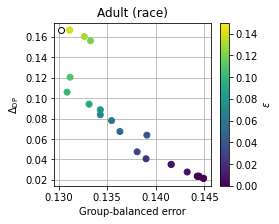

,group_balanced_err,dp_gap
no_postprocess,0.130304,0.166392
0.15,0.131146,0.166431
0.14,0.131146,0.166431
0.13,0.132652,0.160181
0.12,0.133292,0.156014
0.11,0.131193,0.120440
0.1,0.130883,0.105818
0.09,0.133145,0.094074
0.08,0.134304,0.088625
0.07,0.134301,0.083677


In [9]:
predictor = sklearn.linear_model.LinearRegression()
predictor.fit(train_data_pre, train_labels_pre_one_hot)
train_probas_post = projection_simplex(predictor.predict(train_data_post),
                                       axis=1)
test_probas = projection_simplex(predictor.predict(test_data), axis=1)

eps = [
    0.15, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03,
    0.02, 0.01, 0.008, 0.005, 0.002, 0.0015, 0.001, 0.0005, 0.0001, 0.0
]
res = defaultdict(dict)
add_metrics_to_dict(res, "no_postprocess", test_labels,
                    np.argmax(test_probas, axis=1), test_groups, n_groups)
for e in eps:
  postprocessor = PostProcessorDP().fit(train_probas_post,
                                        train_groups_post,
                                        eps=e)
  test_preds = postprocessor.predict(test_probas, test_groups)
  add_metrics_to_dict(res, e, test_labels, test_preds, test_groups, n_groups)

plot_results(eps, res, "Adult (race)")
display(pd.DataFrame(res))

In [10]:
# Get q_by_group under eps=0 from last post-processor in previous cell
q_by_group = postprocessor.q_by_group_

import importlib
import utils

importlib.reload(utils)

predictor = sklearn.linear_model.LinearRegression()
predictor.fit(train_data_pre, train_labels_pre_one_hot)
train_probas_post = projection_simplex(predictor.predict(train_data_post),
                                       axis=1)
test_probas = projection_simplex(predictor.predict(test_data), axis=1)

train_probas_post = utils.perturb(rng,
                                   train_probas_post,
                                   bw=bw,
                                   repeat=n_perturbations_train)
train_labels_post = np.repeat(train_labels_post, n_perturbations_train)
train_groups_post = np.repeat(train_groups_post, n_perturbations_train)

test_probas_perturbed = utils.perturb(rng,
                                       test_probas,
                                       bw=bw,
                                       repeat=n_perturbations_eval)
test_labels_repeated = np.repeat(test_labels, n_perturbations_eval)
test_groups_repeated = np.repeat(test_groups, n_perturbations_eval)

eps = [0.0]
res = defaultdict(dict)
for e in eps:
  postprocessor = PostProcessorDP().fit(train_probas_post,
                                        train_groups_post,
                                        eps=e,
                                        q_by_group=q_by_group)
  test_preds = postprocessor.predict(test_probas_perturbed,
                                     test_groups_repeated)
  add_metrics_to_dict(res, e, test_labels_repeated, test_preds,
                      test_groups_repeated, n_groups)

print("With smoothing:")
display(pd.DataFrame(res))

With smoothing:


,group_balanced_err,dp_gap
0.0,0.143473,0.026505


## Sensitive attribute "Sex" + "Race"

In [11]:
sensitive_attributes = ["Sex", "Race"]
train_groups, test_groups, n_groups = get_group_labels_and_print_statistics(
    sensitive_attributes)
train_data_pre, train_data_post, train_labels_pre, train_labels_post, train_groups_pre, train_groups_post = sklearn.model_selection.train_test_split(
    train_data,
    train_labels,
    train_groups,
    test_size=split_ratio_for_postprocessing,
    random_state=seed)
train_labels_pre_one_hot = pd.get_dummies(train_labels_pre)

Dataset statistics:


Group,"Female, Amer-Indian-Eskimo","Female, Asian-Pac-Islander","Female, Black","Female, Other","Female, White","Male, Amer-Indian-Eskimo","Male, Asian-Pac-Islander","Male, Black","Male, Other","Male, White"
Target,,,,,,,,,,
<=50K,0.918919,0.866538,0.942808,0.929032,0.88163,0.859649,0.660679,0.817417,0.844622,0.684531
>50K,0.081081,0.133462,0.057192,0.070968,0.11837,0.140351,0.339321,0.182583,0.155378,0.315469


Group,"Female, Amer-Indian-Eskimo","Female, Asian-Pac-Islander","Female, Black","Female, Other","Female, White","Male, Amer-Indian-Eskimo","Male, Asian-Pac-Islander","Male, Black","Male, Other","Male, White"
Count,185,517,2308,155,13027,285,1002,2377,251,28735



Perfect results if dataset equals population:


,group_balanced_err,dp_gap
no_postprocess,0.000000,0.282129
postprocess,0.067203,0.000000


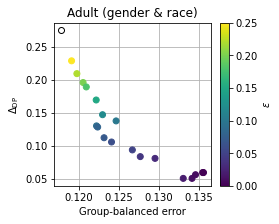

,group_balanced_err,dp_gap
no_postprocess,0.117822,0.275081
0.25,0.119088,0.228597
0.22,0.119752,0.209179
0.2,0.120532,0.195719
0.18,0.120930,0.189025
0.15,0.122172,0.169258
0.12,0.122969,0.146980
0.1,0.124665,0.137566
0.09,0.122212,0.130036
0.08,0.122355,0.128273


In [12]:
predictor = sklearn.linear_model.LinearRegression()
predictor.fit(train_data_pre, train_labels_pre_one_hot)
train_probas_post = projection_simplex(predictor.predict(train_data_post),
                                       axis=1)
test_probas = projection_simplex(predictor.predict(test_data), axis=1)

eps = [
    0.25, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04,
    0.03, 0.02, 0.01, 0.008, 0.001, 0.0
]
res = defaultdict(dict)
add_metrics_to_dict(res, "no_postprocess", test_labels,
                    np.argmax(test_probas, axis=1), test_groups, n_groups)
for e in eps:
  postprocessor = PostProcessorDP().fit(train_probas_post,
                                        train_groups_post,
                                        eps=e)
  test_preds = postprocessor.predict(test_probas, test_groups)
  add_metrics_to_dict(res, e, test_labels, test_preds, test_groups, n_groups)

plot_results(eps, res, "Adult (gender & race)")
display(pd.DataFrame(res))

In [13]:
# Get q_by_group under eps=0 from last post-processor in previous cell
q_by_group = postprocessor.q_by_group_

import importlib
import utils

importlib.reload(utils)

predictor = sklearn.linear_model.LinearRegression()
predictor.fit(train_data_pre, train_labels_pre_one_hot)
train_probas_post = projection_simplex(predictor.predict(train_data_post),
                                       axis=1)
test_probas = projection_simplex(predictor.predict(test_data), axis=1)

train_probas_post = utils.perturb(rng,
                                   train_probas_post,
                                   bw=bw,
                                   repeat=n_perturbations_train)
train_labels_post = np.repeat(train_labels_post, n_perturbations_train)
train_groups_post = np.repeat(train_groups_post, n_perturbations_train)

test_probas_perturbed = utils.perturb(rng,
                                       test_probas,
                                       bw=bw,
                                       repeat=n_perturbations_eval)
test_labels_repeated = np.repeat(test_labels, n_perturbations_eval)
test_groups_repeated = np.repeat(test_groups, n_perturbations_eval)

eps = [0.0]
res = defaultdict(dict)
for e in eps:
  postprocessor = PostProcessorDP().fit(train_probas_post,
                                        train_groups_post,
                                        eps=e,
                                        q_by_group=q_by_group)
  test_preds = postprocessor.predict(test_probas_perturbed,
                                     test_groups_repeated)
  add_metrics_to_dict(res, e, test_labels_repeated, test_preds,
                      test_groups_repeated, n_groups)

print("With smoothing:")
display(pd.DataFrame(res))

With smoothing:


,group_balanced_err,dp_gap
0.0,0.137179,0.063689
